# WMT of tendency terms - play with bin sizes
## CM2.6
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.f5ff454b26224e7c9b7b06d15e2165f0/status,


In [71]:
cluster.close()
client.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba, rho
import fastjmd95
import pop_tools
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
#import gsw

In [2]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [45]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tracer_tendencies.zarr'))
#drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/drhodts_tendencies.zarr'))
cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling.zarr'))
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_lap.zarr'))

tendencies = xr.merge([tracers, cab, rho])

In [46]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    SSS_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SST_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [47]:
res = tendencies.rho_lap + tendencies.cabbeling - tendencies.SSS_lap - tendencies.SST_lap

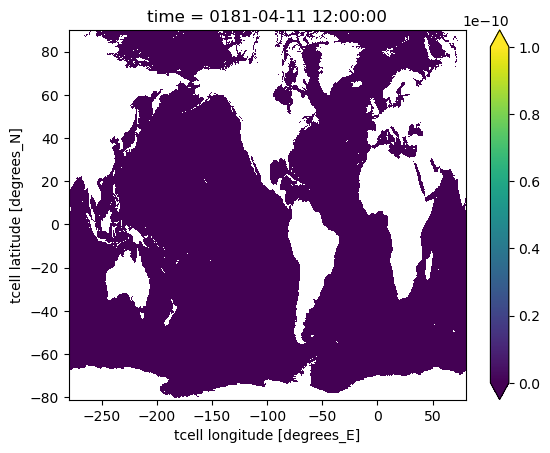

In [48]:
res.isel(time=100).plot(robust=True, vmin=1e-10);

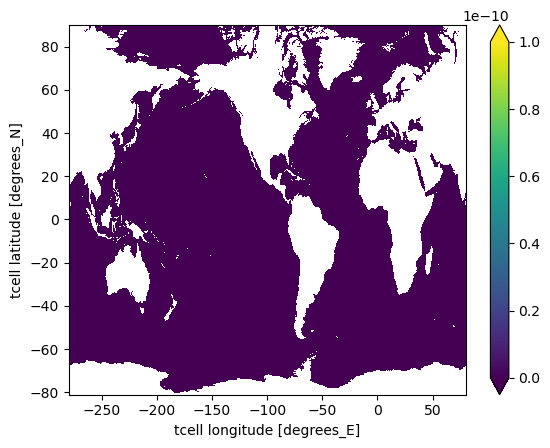

In [49]:
res.mean('time').plot(robust=True, vmin=1e-10);

# Mask by basin

In [5]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-cdpfwg5r
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-cdpfwg5r
  Resolved https://github.com/mathause/regionmask.git to commit 048e2bbee3b5e3ef945139b8a957e8406c4b06df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-ia9rtgp5
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-ia9rtgp5
  Resolved https://github.com/jbusecke/xmip.git to commit 3bc0793f3bc7529a0e49da931e7d2465aa5eefd0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask

<GeoAxes: >

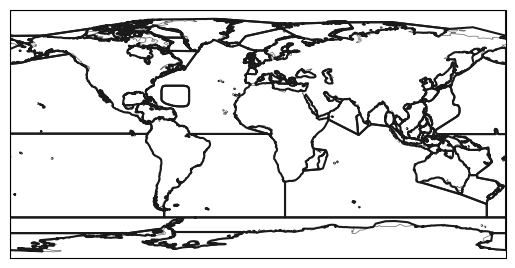

In [8]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [9]:
da = ds.temp.isel(time=0, st_ocean=0).squeeze()

In [10]:
da_renamed = da.rename({'geolat_t':'lat', 'geolon_t':'lon'}).load()

In [11]:
mask = merged_mask(basins, da_renamed)

/srv/conda/envs/notebook/lib/python3.10/site-packages/regionmask/core/mask.py:153: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/pygeos/io.py:523: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


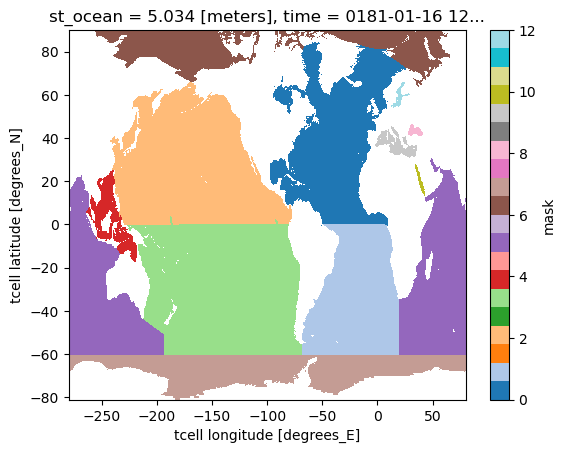

In [21]:
mask.plot(cmap='tab20');

In [12]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
south_china_seas = 4
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7
black_sea = 8
med_sea = 9
red_sea = 10
baltic_sea = 12 #no 11

In [16]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(mask==basin)
    return tendency_in_basin

### Mixing part

In [19]:
tend = tendencies

In [20]:
all_tendencies = list(tend)

In [21]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean = xr.merge([basin_selection(tend[var],
                                       north_atlantic_ocean).rename('NATL_' + var) for var in all_tendencies])
satl_ocean = xr.merge([basin_selection(tend[var], 
                                       south_atlantic_ocean).rename('SATL_' + var) for var in all_tendencies])

#Pacific Ocean
npac_ocean = xr.merge([basin_selection(tend[var], 
                                       north_pacific_ocean).rename('NPAC_' + var) for var in all_tendencies])
spac_ocean = xr.merge([basin_selection(tend[var], 
                                       south_pacific_ocean).rename('SPAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(tend[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(tend[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(tend[var], 
                                        southern_ocean).rename('South_' + var) for var in all_tendencies])

# Run histograms

In [23]:
rmask = mask
#mask_bins = np.arange(rmask.min()-0.5, rmask.max()+0.5)
mask_bins = np.array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 12.5, 99.5])
rho = rho.rho # tendencies.rho
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)

In [24]:
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

### Mixing part (histograms)

In [27]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[prefix+variable].fillna(0.)*(avg_mld*coord.area_t).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

In [53]:
def global_hist_func(ds, variable):
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                    weights=(ds[variable].fillna(0.)*(avg_mld*coord.area_t).fillna(0.)),
                    dim=['xt_ocean', 'yt_ocean']) / delta_rho
    return hist

In [54]:
global_hists = xr.merge([global_hist_func(tendencies, var).rename('OMEGA_' + var) for var in all_tendencies])

In [57]:
global_hists

<xarray.Dataset>
Dimensions:          (time: 7305, rho0_bin: 199)
Coordinates:
  * time             (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_SSS_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_SST_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

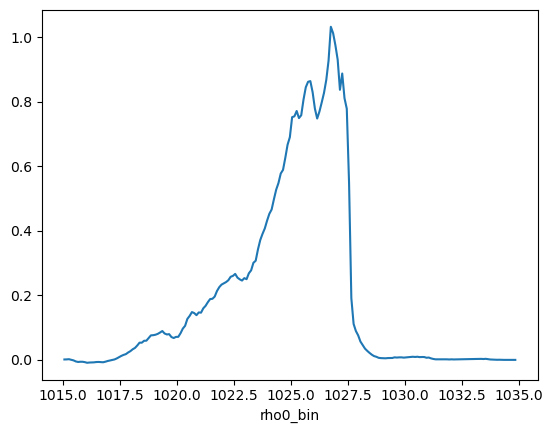

In [61]:
#check residual
((global_hists.OMEGA_rho_lap + global_hists.OMEGA_cabbeling - 
  global_hists.OMEGA_SSS_lap - global_hists.OMEGA_SST_lap)/1e6).mean('time').plot();
#residual around 1027 density bin which makes sense since 1027.1 is the most commonly occuring density

Task exception was never retrieved
future: <Task finished name='Task-3057' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2134> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2143, in wait
    raise AllExit()
distributed.client.AllExit


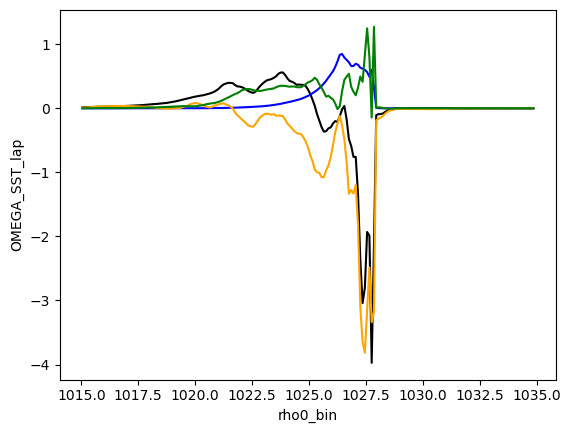

In [67]:
(global_hists.OMEGA_rho_lap/1e6).mean('time').plot(color='k')
(global_hists.OMEGA_cabbeling/1e6).mean('time').plot(color='blue')
(global_hists.OMEGA_SSS_lap/1e6).mean('time').plot(color='orange')
(global_hists.OMEGA_SST_lap/1e6).mean('time').plot(color='green')

In [28]:
#mixing components
natl_hist = xr.merge([histogram_function(natl_ocean, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
satl_hist = xr.merge([histogram_function(satl_ocean, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
npac_hist = xr.merge([histogram_function(npac_ocean, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
spac_hist = xr.merge([histogram_function(spac_ocean, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
ind_hist = xr.merge([histogram_function(ind_ocean, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
arc_hist = xr.merge([histogram_function(arc_ocean, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
south_hist = xr.merge([histogram_function(south_ocean, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_tendencies])